In [1]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import initializers

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


[Agrimonia_Dataset](https://zenodo.org/record/6620530#.Y1Fkf3bP1PY)
- [Air quality index](https://airindex.eea.europa.eu/Map/AQI/Viewer/#)
- [Air quality index2](https://www.euronews.com/weather/copernicus-air-quality-index)

### Data cleaning

In [2]:
df = pd.read_csv("./data/Agrimonia_Dataset.csv",low_memory=False)

In [3]:
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [4]:
# Check shape of the data set
df.shape

(309072, 41)

In [5]:
# Check type of the data set
df.dtypes

IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_pm25                         object
AQ_co                           object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
AQ_so2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipication_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_10

In [6]:
# Check missing value in the data set
df.isnull().sum()[df.isnull().sum() != 0]

LA_land_use      6576
LA_soil_use    160738
dtype: int64

In [7]:
# Select object columns
object_col = df.select_dtypes(include='object').columns
object_col

Index(['IDStations', 'Time', 'AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox',
       'AQ_no2', 'AQ_so2', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine'],
      dtype='object')

In [8]:
# `NaN` in the air quality columns is imputed the value 
# which is noise of the data.
aq_col = ['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3',
          'AQ_nox', 'AQ_no2', 'AQ_so2']
for col in list(aq_col):
    print(f"Missing value 'NaN' in column {col}: {df[col].str.contains('NaN').sum()}")

Missing value 'NaN' in column AQ_pm10: 89634
Missing value 'NaN' in column AQ_pm25: 208379
Missing value 'NaN' in column AQ_co: 197180
Missing value 'NaN' in column AQ_nh3: 292617
Missing value 'NaN' in column AQ_nox: 107843
Missing value 'NaN' in column AQ_no2: 49132
Missing value 'NaN' in column AQ_so2: 227026


In [9]:
# Remove space of `NaN` value in dataframe
df = df.replace('\s+','',regex=True)

In [10]:
# Impute missing all `NaN` value with 0
df = df.replace('NaN',0)
df = df.fillna(0)
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,0,0,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,0,0,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,0,0,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,0,0,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,0,0,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [11]:
# Convert object column except 'IDStations', 'Time','WE_mode_wind_direction_10m' and, 
# 'WE_mode_wind_direction_100m' columns to float
to_float_col = df.select_dtypes(include='object').drop(columns=['IDStations', 'Time',
                 'WE_mode_wind_direction_10m', 
                 'WE_mode_wind_direction_100m']).columns
for col in to_float_col:
    df[col] = df[col].astype(float)
df[to_float_col].dtypes

AQ_pm10                  float64
AQ_pm25                  float64
AQ_co                    float64
AQ_nh3                   float64
AQ_nox                   float64
AQ_no2                   float64
AQ_so2                   float64
EM_nh3_livestock_mm      float64
EM_nh3_agr_soils         float64
EM_nh3_agr_waste_burn    float64
EM_nh3_sum               float64
EM_nox_traffic           float64
EM_nox_sum               float64
EM_so2_sum               float64
LI_pigs                  float64
LI_bovine                float64
dtype: object

In [12]:
# Number of row that have value of 0
(df == 0).sum()[(df == 0).sum() != 0]

AQ_pm10                   90053
AQ_pm25                  208699
AQ_co                    197297
AQ_nh3                   293053
AQ_nox                   107843
AQ_no2                    49136
AQ_so2                   227037
WE_tot_precipitation      10224
WE_precipication_t       213689
EM_nh3_livestock_mm       51465
EM_nh3_agr_soils          51465
EM_nh3_agr_waste_burn     54492
EM_nh3_sum                51465
EM_nox_traffic            51465
EM_nox_sum                51465
EM_so2_sum                51465
LI_pigs                   45714
LI_bovine                 24674
LA_land_use                6576
LA_soil_use              173478
dtype: int64

In [13]:
df['IDStations'].nunique()

141

In [14]:
df['Time'] = pd.to_datetime(df['Time'])

In [15]:
# df.describe().round(2).T[['mean','std','min','50%','max']]

In [16]:
# Convert `WE_surface_pressure` and `WE_solar_radiation` unit
# to MPa and MJ/m^2 respectively
# Divided the value in this 2 columns by 100_000
# Purpose: change the scale of the data
df['WE_surface_pressure'] = df['WE_surface_pressure']/100_000
df['WE_solar_radiation'] = df['WE_solar_radiation']/100_000

In [17]:
df_time = df.copy()

In [18]:
# Set time to index
df_time.set_index('Time',inplace=True)

In [19]:
df_time.head(1)

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0


In [20]:
df_time.columns

Index(['IDStations', 'Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25',
       'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2', 'WE_temp_2m',
       'WE_wind_speed_10m_mean', 'WE_wind_speed_10m_max',
       'WE_mode_wind_direction_10m', 'WE_tot_precipitation',
       'WE_precipication_t', 'WE_surface_pressure', 'WE_solar_radiation',
       'WE_rh_min', 'WE_rh_mean', 'WE_rh_max', 'WE_wind_speed_100m_mean',
       'WE_wind_speed_100m_max', 'WE_mode_wind_direction_100m',
       'WE_blh_layer_max', 'WE_blh_layer_min', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine',
       'LA_hvi', 'LA_lvi', 'LA_land_use', 'LA_soil_use'],
      dtype='object')

In [21]:
# Check the available value of AQ_nh3 in the dataset 
df[df['AQ_nh3'] != 0]['IDStations'].value_counts()

677     2119
626     2081
1266    1896
642     1835
573     1736
693     1671
705     1587
703     1528
681     1273
583      293
Name: IDStations, dtype: int64

### EDA

In [22]:
aq_col = df.columns[df.columns.str.contains('AQ')]
aq_col

Index(['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2'], dtype='object')

In [23]:
overall_station_polltion = df.groupby(['IDStations']).mean()[aq_col].round(2)
overall_station_polltion.head()

,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,AQ_so2
IDStations,,,,,,,
1264,21.57,17.25,0.00,0.00,37.46,18.59,0.0
1265,30.33,23.19,0.00,0.00,53.01,28.62,0.0
1266,30.49,0.00,0.00,29.57,37.90,22.44,0.0
1269,27.94,22.85,0.48,0.00,49.31,27.57,0.0
1274,0.00,0.00,0.00,0.00,20.64,15.20,0.0


In [24]:
def top5_pollution(quality):
    return overall_station_polltion.sort_values(f'AQ_{quality}',ascending=False)\
[[f'AQ_{quality}']].head()

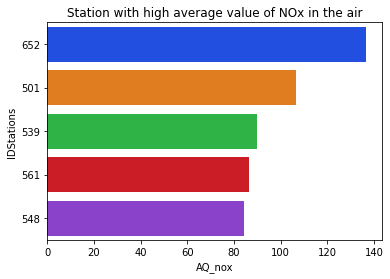

In [25]:
# 5 station that have highest overall amount of NOx in the air
sns.barplot(y=top5_pollution('nox').index, x = 'AQ_nox',data = top5_pollution('nox'))
plt.title('Station with high average value of NOx in the air');

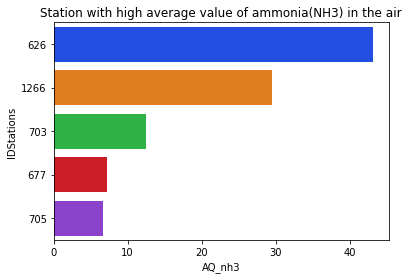

In [26]:
# 5 station that have highest overall amount of NH3 in the air
sns.barplot(y=top5_pollution('nh3').index, x = 'AQ_nh3',data = top5_pollution('nh3'))
plt.title('Station with high average value of ammonia(NH3) in the air');

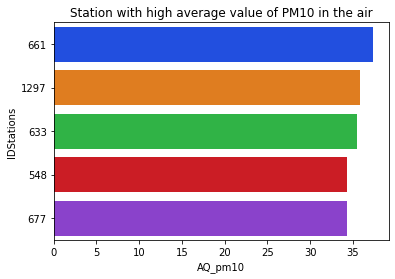

In [27]:
# 5 station that have highest overall amount of pm10 in the air
sns.barplot(y=top5_pollution('pm10').index, x = 'AQ_pm10',data = top5_pollution('pm10'))
plt.title('Station with high average value of PM10 in the air');

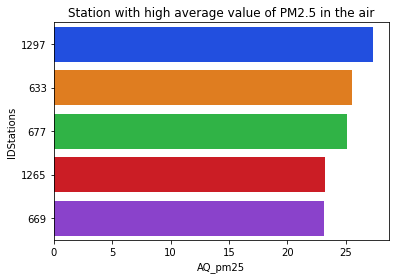

In [28]:
# 5 station that have highest overall amount of pm2.5 in the air
sns.barplot(y=top5_pollution('pm25').index, x = 'AQ_pm25',data = top5_pollution('pm25'))
plt.title('Station with high average value of PM2.5 in the air');

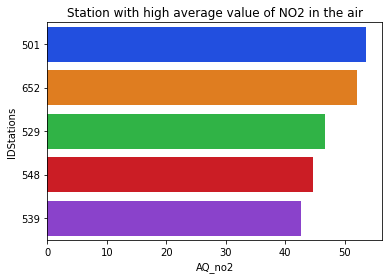

In [29]:
# 5 station that have highest overall amount of NO2 in the air
sns.barplot(y=top5_pollution('no2').index, x = 'AQ_no2',data = top5_pollution('no2'))
plt.title('Station with high average value of NO2 in the air');

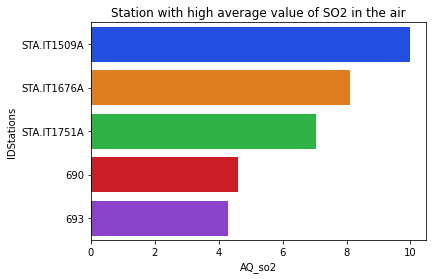

In [30]:
# 5 station that have highest overall amount of SO2 in the air
sns.barplot(y=top5_pollution('so2').index, x = 'AQ_so2',data = top5_pollution('so2'))
plt.title('Station with high average value of SO2 in the air');

### Air Quality: NOx

#### Time series linear model for station 652

In [31]:
def extract_aq_df(quality, station):
    """Filter dataframe which contain the value of air quality in the given station"""
    df = df_time[df_time[f'AQ_{quality}'] != 0]\
    [df_time[df_time[f'AQ_{quality}'] != 0]['IDStations'] == station]
    return df

In [32]:
def station_daily_nox(station):
    plt.figure(figsize=(15,6))
    df_nox = extract_aq_df('nox',station)
    plt.plot(df_nox['AQ_nox'], color='royalblue')
    plt.title(f'Weekly NOx quantity of station {station}',fontsize=18)
    plt.ylabel('NOx', fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.axhline(df_nox['AQ_nox'].mean(),color='salmon');

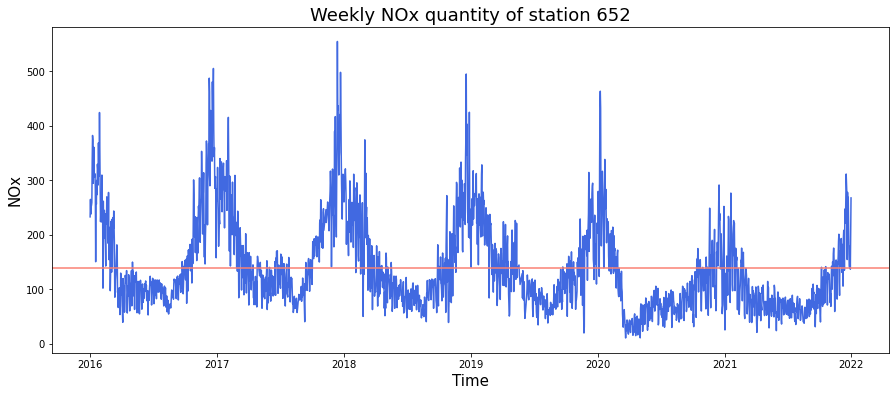

In [33]:
# NOx quantity of station 652
station_daily_nox('652')

Autocorrelation additional information: 
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/m
- https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Parial Autocorrelation additional information:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

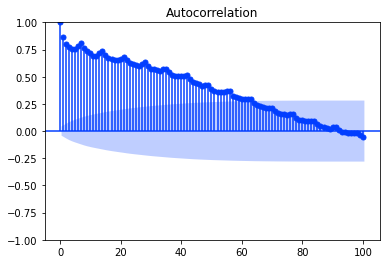

In [34]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=100);

(0.0, 20.0)

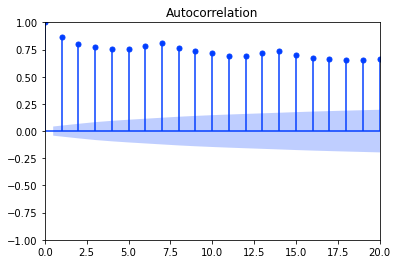

In [35]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=400);
plt.xlim(0,20)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


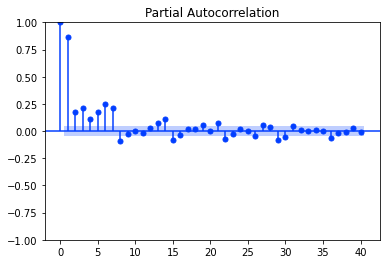

In [36]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('nox','652')['AQ_nox'],lags=40);

In [37]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [38]:
# adfuller for checking the trend of station's 652 data
interpret_dftest(adfuller(extract_aq_df('nox','652')['AQ_nox'].dropna()))
# No trend

Test Statistic   -3.447531
p-value           0.009441
dtype: float64

In [39]:
def train_test_time_series(station, quality,test_size=0.1):
    train, test = train_test_split(extract_aq_df(quality,station)[f'AQ_{quality}'],
                                       test_size=test_size,
                                       shuffle=False)
    # Fix freq of data
    train.index = train.index.to_period('d')
    test.index = test.index.to_period('d')
    return train, test

In [40]:
train, test = train_test_time_series('652', 'nox',test_size=0.05) 

In [41]:
train.shape, test.shape

((2049,), (108,))

In [42]:
train.tail()

Time
2021-09-10    101.50
2021-09-11     78.19
2021-09-12     67.15
2021-09-13    109.40
2021-09-14     91.73
Freq: D, Name: AQ_nox, dtype: float64

In [43]:
def fit_preds(stat_model, test, show_aic=True, show_mse=True):
    model = stat_model.fit()
    # preds = model.predict(start=train.shape[0], end=(train.shape[0]+test.shape[0]-1))
    preds = model.predict(start=test.index[0], end=test.index[-1])
    if show_aic:
        print(f'AIC: {model.aic}')
    if show_mse:
        print(f'MSE: {mean_squared_error(test, preds)}')
    return preds, model.aic, mean_squared_error(test, preds)

In [44]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(10,0,10))
preds = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 20426.190557941904
MSE: 3249.735923551522


In [45]:
def station_arima_graph(train, test, preds, quality_title, station):
    # Plot data.
    plt.figure(figsize=(15,6))

    # Plot training data in blue.
    #plt.plot(train, color = 'royalblue')
    sns.lineplot(x=train.index.to_timestamp(), y=train, color = 'royalblue')

    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange')

    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green')

    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.show();

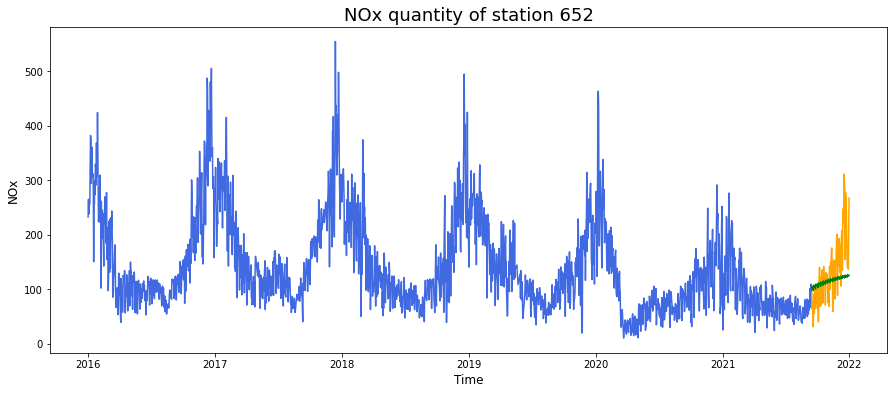

In [46]:
station_arima_graph(train, test, preds[0],'NOx','652')

In [47]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
# count = 0
# for p in p_list:
#     for d in d_list:
#         for q in q_list:
#             ar1 = ARIMA(endog=train, order=(p,d,q))
#             preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
#             manual_grid.loc[count] = [p, d, q, aic, mse]
#             count += 1

In [48]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nox_arima_gridsearch.csv')

In [49]:
manual_grid.sort_values('mse').head(10)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,p,d,q,aic,mse
18,18,18,18,8.0,0.0,8.0,20421.192271,3131.433324
26,26,26,26,9.0,0.0,8.0,20425.767966,3134.724902
27,27,27,27,9.0,0.0,9.0,20422.122378,3316.109884
0,0,0,0,6.0,0.0,6.0,20470.080954,3351.673203
9,9,9,9,7.0,0.0,7.0,20456.101769,3450.973592
16,16,16,16,8.0,0.0,6.0,20508.092173,3626.832648
11,11,11,11,7.0,0.0,9.0,20444.536899,3636.841274
24,24,24,24,9.0,0.0,6.0,20493.019923,3677.675062
17,17,17,17,8.0,0.0,7.0,20430.683126,4109.760459
8,8,8,8,7.0,0.0,6.0,20452.242686,4205.481335


In [50]:
manual_grid.to_csv('./saved_data/nox_arima_gridsearch.csv')

In [51]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,8))
preds = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 20421.192271111875
MSE: 3131.433323838929


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
preds

(2021-09-15    101.654495
 2021-09-16    106.155310
 2021-09-17    107.179074
 2021-09-18    100.352964
 2021-09-19    100.094758
                  ...    
 2021-12-27    129.616543
 2021-12-28    126.556241
 2021-12-29    124.868577
 2021-12-30    128.446229
 2021-12-31    128.830004
 Freq: D, Name: predicted_mean, Length: 108, dtype: float64,
 20421.192271111875,
 3131.433323838929)

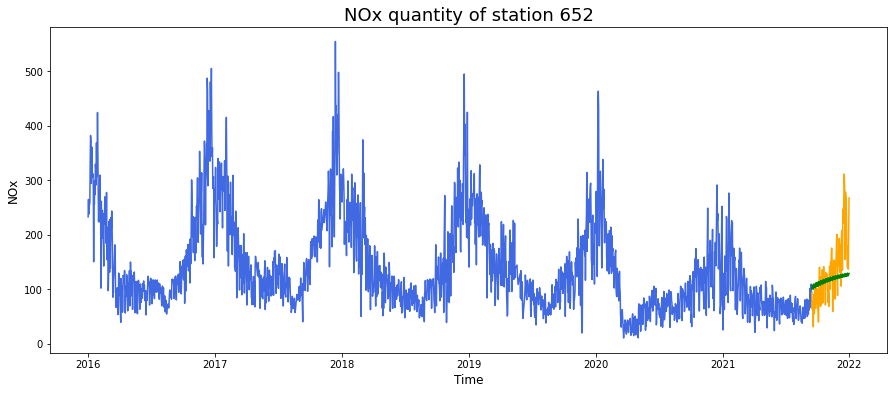

In [53]:
station_arima_graph(train, test, preds[0],'NOx','652')

In [54]:
def test_pred_graph(test,preds,station):
    # Plot data.
    plt.figure(figsize=(10,6))
    # Plot testing data in orange.
    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange')
    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green')
    plt.title(label = f'Station {station}', fontsize=18)
    plt.show();

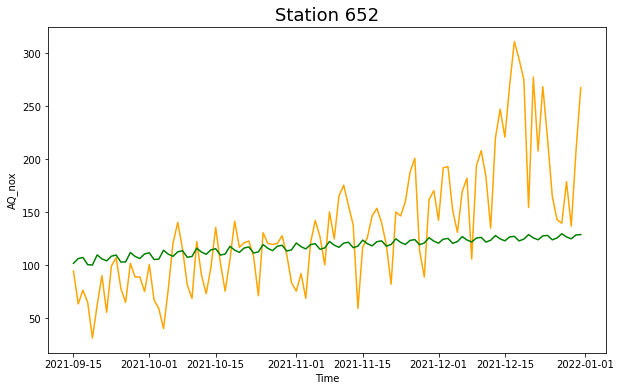

In [55]:
test_pred_graph(test,preds[0],'652')

#### RNN model

In [56]:
# LSTM
data = extract_aq_df('nox','652')
data.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,652,45.539529,10.231786,154,0.0,0.0,1.025,0.0,232.7,54.58,...,7.517,6.432,62.04,38.47,0.3875,16.41,1.937,2.165,112.0,17.0
2016-01-02,652,45.539529,10.231786,154,0.0,0.0,1.275,0.0,264.8,54.05,...,7.539,6.423,62.07,38.50,0.3875,16.39,1.937,2.165,112.0,17.0
2016-01-03,652,45.539529,10.231786,154,0.0,0.0,1.317,0.0,237.7,50.54,...,7.563,6.412,62.12,38.53,0.3875,16.38,1.937,2.164,112.0,17.0
2016-01-04,652,45.539529,10.231786,154,0.0,0.0,1.096,0.0,251.2,60.62,...,7.587,6.401,62.19,38.57,0.3875,16.38,1.936,2.164,112.0,17.0
2016-01-05,652,45.539529,10.231786,154,0.0,0.0,1.179,0.0,254.2,52.53,...,7.612,6.388,62.26,38.60,0.3875,16.37,1.936,2.164,112.0,17.0


In [57]:
X = data.select_dtypes(exclude = 'object').drop(columns=['Latitude', 'Longitude', 'Altitude',
                                                     'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',
                                                     'AQ_nox','AQ_no2','AQ_so2'])
y = data['AQ_nox']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [59]:
X_train.tail()

,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_tot_precipitation,WE_precipication_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-01,23.29,0.7442,1.539,0.033020,0,0.9722,170.4,89.98,94.31,99.24,...,14.71,3.566,28.69,11.20,0.6642,14.59,3.010,3.189,112.0,0.0
2020-07-02,23.34,1.0340,1.703,0.024070,0,0.9710,205.1,85.68,93.50,99.60,...,14.68,3.545,28.66,11.20,0.6642,14.59,3.014,3.193,112.0,0.0
2020-07-03,20.66,1.0620,2.013,0.180700,1,0.9734,153.2,90.45,95.15,98.56,...,14.64,3.519,28.61,11.19,0.6642,14.59,3.018,3.197,112.0,0.0
2020-07-04,21.49,0.8490,1.461,0.017120,0,0.9774,191.0,85.87,91.90,97.48,...,14.59,3.491,28.55,11.18,0.6642,14.59,3.022,3.201,112.0,0.0
2020-07-05,22.40,1.0350,1.475,0.000309,0,0.9766,204.0,87.03,92.68,98.44,...,14.53,3.459,28.46,11.17,0.6642,14.59,3.026,3.205,112.0,0.0


In [60]:
X_test.head()

,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_tot_precipitation,WE_precipication_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-06,23.69,1.0790,1.872,0.000311,0,0.9705,210.1,85.02,92.49,99.14,...,14.47,3.424,28.37,11.15,0.6642,14.59,3.030,3.209,112.0,0.0
2020-07-07,20.23,1.8670,3.085,0.011750,0,0.9757,181.5,84.23,89.81,95.04,...,14.39,3.387,28.25,11.13,0.6642,14.59,3.035,3.213,112.0,0.0
2020-07-08,20.76,0.7866,1.422,0.000732,0,0.9775,188.2,85.34,88.89,95.93,...,14.31,3.347,28.13,11.10,0.6642,14.59,3.039,3.217,112.0,0.0
2020-07-09,22.16,0.9960,1.526,0.000039,0,0.9771,208.9,84.68,90.76,97.35,...,14.23,3.306,27.99,11.07,0.6642,14.59,3.043,3.221,112.0,0.0
2020-07-10,23.55,1.1870,1.949,0.000283,0,0.9749,221.3,83.65,90.87,97.72,...,14.14,3.262,27.85,11.04,0.6642,14.59,3.047,3.225,112.0,0.0


In [61]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [62]:
# This class takes in a sequence of data-points gathered at
# equal intervals, along with time series parameters such as
# stride, length of history, etc.
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                    length=3, batch_size=64)


In [63]:
train_sequences[0][0][0].shape

(3, 27)

In [64]:
input_shape = train_sequences[0][0][0].shape

In [65]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(64, input_shape=input_shape, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])

Epoch 1/100
26/26 [==============================] - 2s 20ms/step - loss: 30350.1230 - val_loss: 12976.1240
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 30232.6387 - val_loss: 12915.9297
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 30045.0039 - val_loss: 12819.1729
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 29670.3008 - val_loss: 12614.1660
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 28865.9199 - val_loss: 12165.9473
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 27359.0801 - val_loss: 11261.9014
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 25210.4297 - val_loss: 9956.2314
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 22461.4570 - val_loss: 8144.9741
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 19168.0957 - val_loss: 6469.9785
Epoch 10/100
26/26 [===================

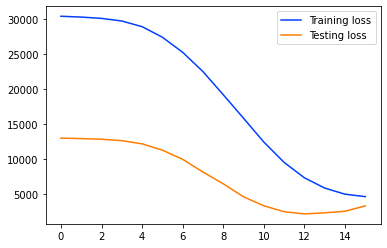

In [66]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

In [67]:
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


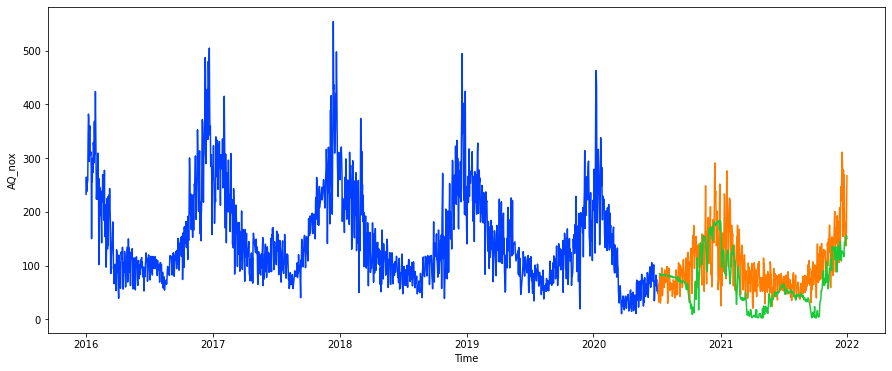

In [68]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0]);

#### LSTM
- [LSTM Example](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [104]:
# LSTM
data = extract_aq_df('nox','652')
data.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,652,45.539529,10.231786,154,0.0,0.0,1.025,0.0,232.7,54.58,...,7.517,6.432,62.04,38.47,0.3875,16.41,1.937,2.165,112.0,17.0
2016-01-02,652,45.539529,10.231786,154,0.0,0.0,1.275,0.0,264.8,54.05,...,7.539,6.423,62.07,38.50,0.3875,16.39,1.937,2.165,112.0,17.0
2016-01-03,652,45.539529,10.231786,154,0.0,0.0,1.317,0.0,237.7,50.54,...,7.563,6.412,62.12,38.53,0.3875,16.38,1.937,2.164,112.0,17.0
2016-01-04,652,45.539529,10.231786,154,0.0,0.0,1.096,0.0,251.2,60.62,...,7.587,6.401,62.19,38.57,0.3875,16.38,1.936,2.164,112.0,17.0
2016-01-05,652,45.539529,10.231786,154,0.0,0.0,1.179,0.0,254.2,52.53,...,7.612,6.388,62.26,38.60,0.3875,16.37,1.936,2.164,112.0,17.0


In [105]:
X = data.select_dtypes(exclude = 'object').drop(columns=['Latitude', 'Longitude', 'Altitude',
                                                     'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',
                                                     'AQ_nox','AQ_no2','AQ_so2'])
y = data['AQ_nox']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [107]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [108]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)
input_shape = train_sequences[0][0][0].shape

**ELU activation**
- ELU is very similiar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes. [[Ref.]](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=ELU%20is%20very%20similiar%20to,%CE%B1%20whereas%20RELU%20sharply%20smoothes.&text=Pros-,ELU%20becomes%20smooth%20slowly%20until%20its%20output%20equal,%CE%B1%20whereas%20RELU%20sharply%20smoothes.)

In [109]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])

Epoch 1/100
26/26 [==============================] - 4s 38ms/step - loss: 30289.2168 - val_loss: 12868.3418
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 30126.9805 - val_loss: 12743.5615
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 29786.9688 - val_loss: 12488.7256
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 29119.1719 - val_loss: 11964.7305
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 27768.2598 - val_loss: 11094.2080
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 25436.2383 - val_loss: 9530.3691
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 21570.3418 - val_loss: 7151.6768
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 16182.6895 - val_loss: 4007.0764
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 9376.6768 - val_loss: 1995.5093
Epoch 10/100
26/26 [=====================

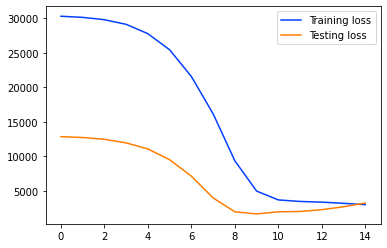

In [110]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

In [111]:
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 4ms/step


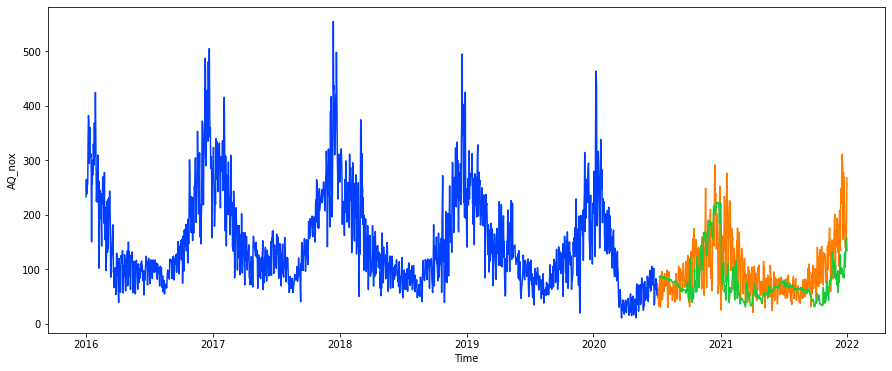

In [112]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0]);

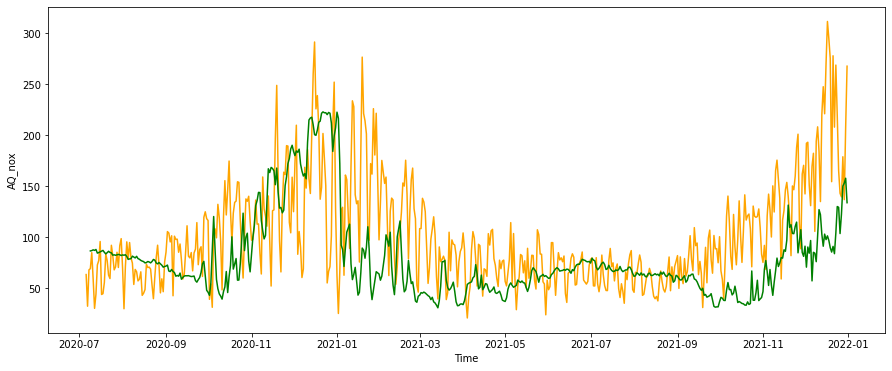

In [113]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_test.index, y=y_test,color='orange')
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0],color='green');

### Air Quality: NH3

#### station 677

In [79]:
nh3_677 = extract_aq_df('nh3', '677')
nh3_677.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,677,45.142541,10.043836,43,50.0,38.0,0.5583,9.0,62.27,29.30,...,9.231,4.257,22.38,9.757,132.8,45.84,1.855,1.689,121.0,17.0
2016-01-02,677,45.142541,10.043836,43,46.0,40.0,0.4833,2.8,54.07,33.36,...,9.268,4.263,22.38,9.776,133.0,45.85,1.854,1.688,121.0,17.0
2016-01-03,677,45.142541,10.043836,43,38.0,33.0,0.4625,1.6,41.12,32.08,...,9.303,4.269,22.39,9.795,133.1,45.88,1.854,1.687,121.0,17.0
2016-01-04,677,45.142541,10.043836,43,33.0,31.0,0.4667,1.4,43.61,30.13,...,9.336,4.276,22.40,9.814,133.3,45.89,1.854,1.687,121.0,17.0
2016-01-05,677,45.142541,10.043836,43,0.0,34.0,0.5292,2.1,65.51,32.54,...,9.367,4.282,22.41,9.834,133.4,45.92,1.854,1.686,121.0,17.0


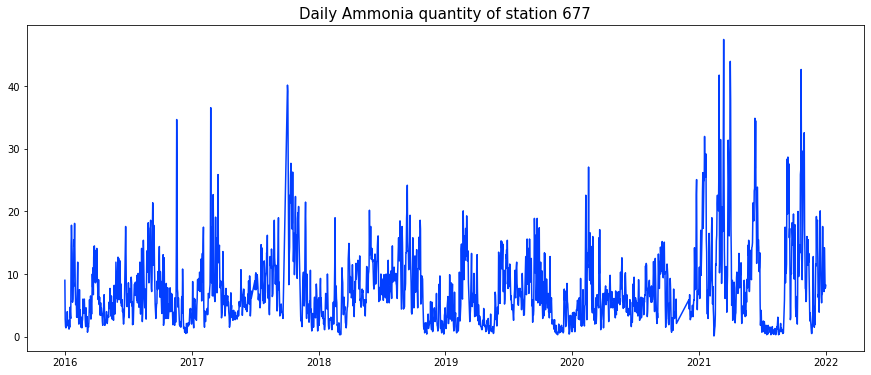

In [80]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677['AQ_nh3'])
plt.title('Daily Ammonia quantity of station 677',fontsize=15);

In [81]:
nh3_677_weekly = nh3_677.resample('W').mean()

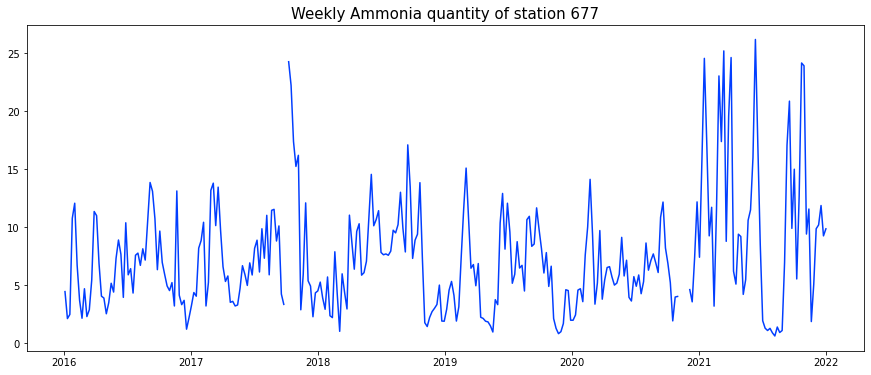

In [82]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677_weekly['AQ_nh3'])
plt.title('Weekly Ammonia quantity of station 677',fontsize=15);

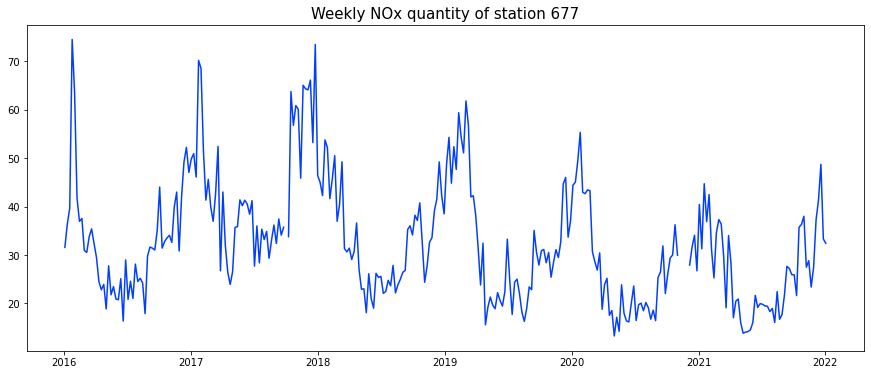

In [83]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677_weekly['AQ_no2'])
plt.title('Weekly NOx quantity of station 677',fontsize=15);

### Air quaility: PM10

In [84]:
def station_daily_pm10(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm10', '1264')
    plt.plot(df_aq['AQ_pm10'], color='royalblue')
    plt.title(f'Daily PM10 quantity of station {station}',fontsize=18)
    plt.ylabel('PM10', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm10'].mean(),color='salmon');

In [85]:
extract_aq_df('pm10','1264').head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0
2016-01-02,1264,46.167852,9.87921,290,73.0,63.0,0.0,0.0,101.70,38.84,...,0.6298,0.8372,1.72,0.3911,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-03,1264,46.167852,9.87921,290,44.0,39.0,0.0,0.0,66.26,32.34,...,0.6424,0.8384,1.72,0.3916,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-04,1264,46.167852,9.87921,290,31.0,29.0,0.0,0.0,63.31,31.67,...,0.6545,0.8396,1.72,0.3923,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-05,1264,46.167852,9.87921,290,27.0,26.0,0.0,0.0,75.53,33.33,...,0.6660,0.8409,1.72,0.3931,0.3832,5.892,3.997,1.233,112.0,17.0


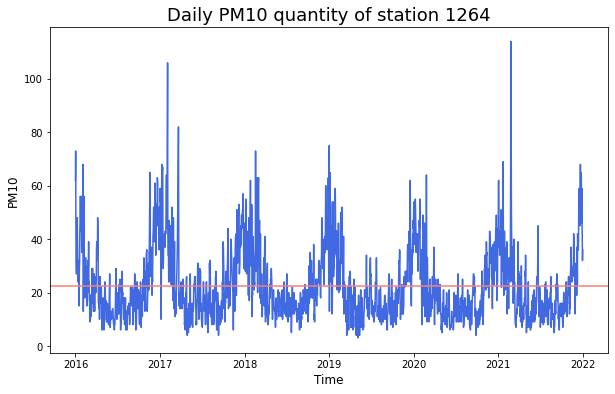

In [86]:
station_daily_pm10('1264')

In [87]:
train, test = train_test_time_series('1264', 'pm10',test_size=0.04) 

In [88]:
train.shape, test.shape

((2026,), (85,))

In [89]:
test.index[0] - test.index[-1]

<-84 * Days>

In [90]:
test.index[-1]

Period('2021-12-31', 'D')

In [91]:
# Fit model ARIMA
ar = ARIMA(endog=train, order=(30,1,30))
preds = fit_preds(ar, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 13823.780793405367
MSE: 536.4560004890849


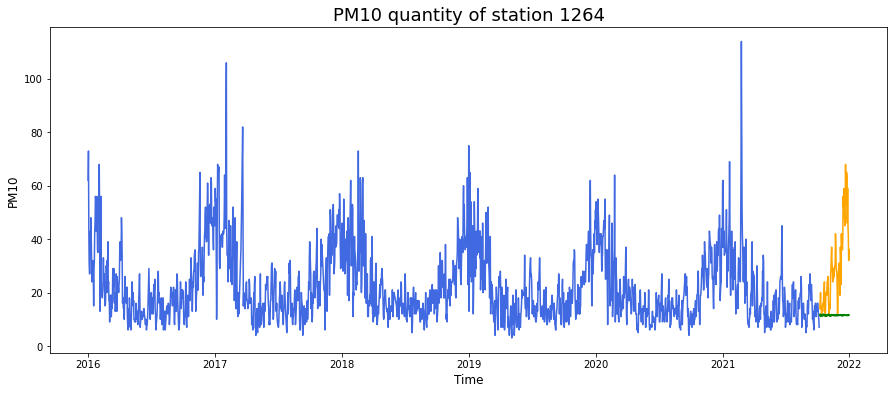

In [92]:
station_arima_graph(train, test, preds[0],'PM10','1264')

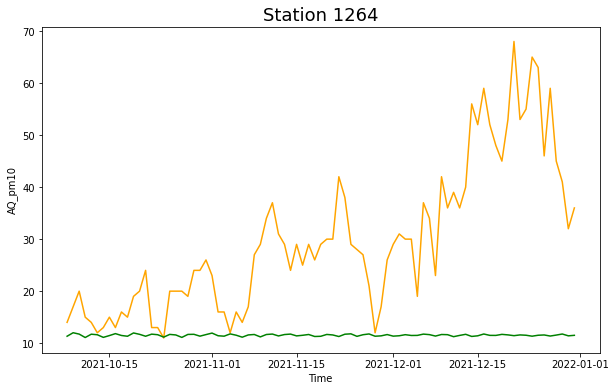

In [93]:
test_pred_graph(test,preds[0],'1264')

In [94]:
def station_weekly_pm10(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm10', station).resample('W').mean()
    plt.plot(df_aq['AQ_pm10'], color='royalblue')
    plt.title(f'Weekly PM10 quantity of station {station}',fontsize=18)
    plt.ylabel('PM10', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm10'].mean(),color='salmon');

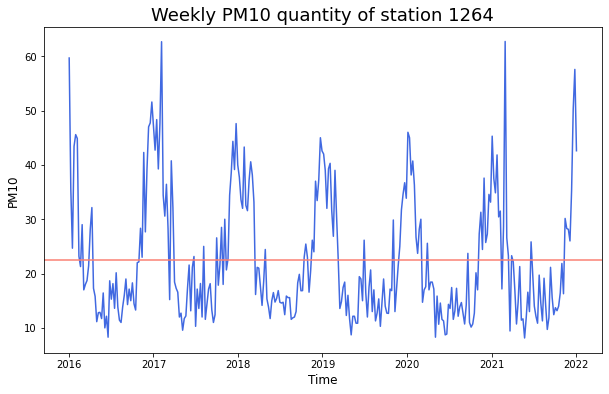

In [95]:
station_weekly_pm10('1264')

### Air quaility: PM2.5

In [96]:
# Station that have the data about amount of PM2.5 in the air 
df_time[df_time['AQ_pm25'] != 0]['IDStations'].value_counts().head()

1297           2152
627            2146
592            2135
STA.IT2121A    2131
583            2130
Name: IDStations, dtype: int64

In [97]:
def station_daily_pm25(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm25', station)
    plt.plot(df_aq['AQ_pm25'], color='royalblue')
    plt.title(f'Daily PM2.5 quantity of station {station}',fontsize=18)
    plt.ylabel('PM2.5', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm25'].mean(),color='salmon');

In [98]:
def station_weekly_pm25(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm25', station).resample('W').mean()
    plt.plot(df_aq['AQ_pm25'], color='royalblue')
    plt.title(f'Weekly PM2.5 quantity of station {station}',fontsize=18)
    plt.ylabel('PM2.5', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm25'].mean(),color='salmon');

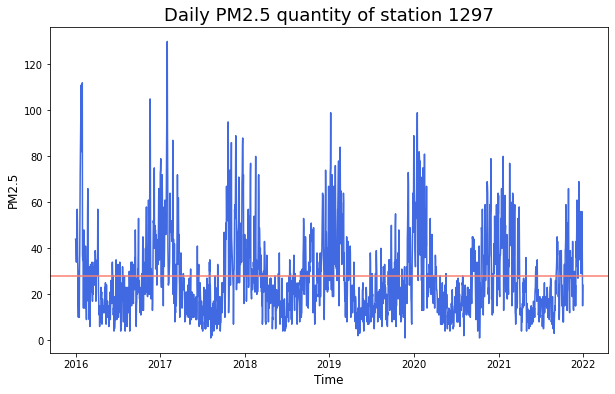

In [99]:
station_daily_pm25('1297')

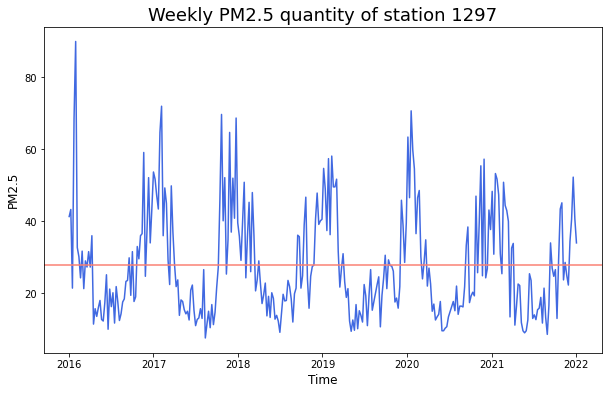

In [100]:
station_weekly_pm25('1297')

### Air quality: NO2

In [101]:
high_no2_station = df[df['AQ_no2'] != 0].groupby(['IDStations']).mean()[['AQ_no2']]\
.sort_values('AQ_no2', ascending=False)
high_no2_station.head()

,AQ_no2
IDStations,
501,56.814509
652,52.983928
529,51.737712
548,47.769415
539,46.317854


In [102]:
def station_daily_no2(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('no2', station)
    plt.plot(df_aq['AQ_no2'], color='royalblue')
    plt.title(f'Weekly NO2 quantity of station {station}',fontsize=18)
    plt.ylabel('NO2', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_no2'].mean(),color='salmon');

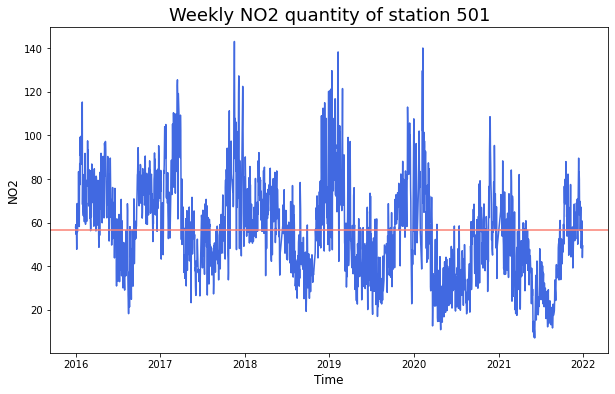

In [103]:
station_daily_no2('501')